In [13]:
import os

# временно останавливаем tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem.rdchem import HybridizationType
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import Draw
from IPython.display import display,Image
rdBase.DisableLog('rdApp.error')

Датасет содержит информацию об экспериментальных (expt) и рассчетных (calc) энергиях гидратации небольших органических молекул. Всего 642 молекулы   
**В целевой модели: инпут - SMILES, аутпут - expt** 

In [2]:
# загрузка данных для тренировки модели по ссылке
molecules_data = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv')
molecules_data

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917
...,...,...,...,...
637,methyl octanoate,CCCCCCCC(=O)OC,-2.04,-3.035
638,pyrrolidine,C1CCNC1,-5.48,-4.278
639,4-hydroxybenzaldehyde,c1cc(ccc1C=O)O,-8.83,-10.050
640,1-chloroheptane,CCCCCCCCl,0.29,1.467


In [3]:
# краткая проверка данных на наличие пропущенных значений
molecules_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   iupac   642 non-null    object 
 1   smiles  642 non-null    object 
 2   expt    642 non-null    float64
 3   calc    642 non-null    float64
dtypes: float64(2), object(2)
memory usage: 20.2+ KB


             expt        calc
count  642.000000  642.000000
mean    -3.803006   -3.486223
std      3.847820    4.186301
min    -25.470000  -21.762000
25%     -5.727500   -5.421500
50%     -3.530000   -3.053500
75%     -1.215000   -0.480750
max      3.430000    3.335000


Text(0.5, 1.0, "Распределение переменной 'expt' в датасете")

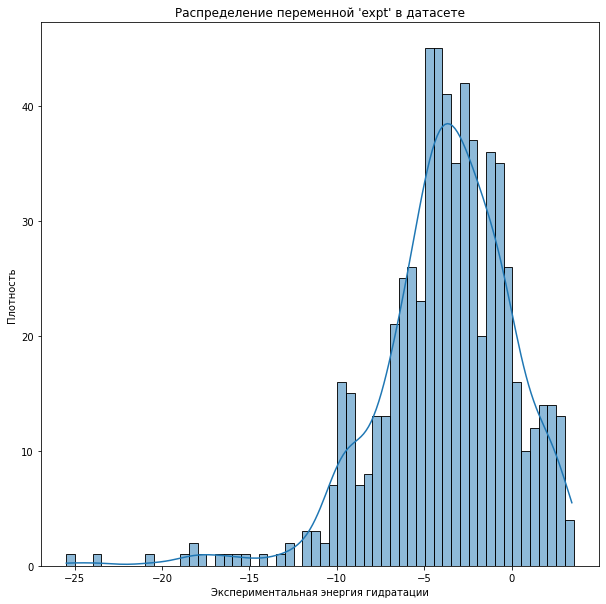

In [4]:
# описательная информация
print(molecules_data.describe())

# визуализация распределения целевой переменной
plt.figure(figsize=(10,10))
sns.histplot(molecules_data['expt'], binwidth=0.5, kde=True)

plt.xlabel("Экспериментальная энергия гидратации") # Text for X-Axis
plt.ylabel("Плотность") # Text for Y-Axis
plt.title("Распределение переменной 'expt' в датасете")

Видно, что данные охватывают широкий диапазон значений энергий. При этом 75% энергий имеют значение больше -5.7, выборка имеет "хвост" в виде набора соединений с относительно низкими энергиями. Это важно учесть при разюиении данных и анализе результатов обучения.  

In [9]:
# рассмотрим, какие атомы у нас есть среди молекул
present_atoms = []
for m in molecules_data.smiles:
    mol = Chem.rdmolfiles.MolFromSmiles(m)
    for a in mol.GetAtoms():
        if a.GetSymbol() not in present_atoms:
            present_atoms.append(a.GetSymbol())
    
print(*present_atoms)

C N O S Cl Br P F I


### Перейдем к подготовке данных для обучения    
Дальнешая подготовка молекулярных графов выполнена на основе кода: https://git.rwth-aachen.de/avt-svt/public/graph_neural_network_for_fuel_ignition_quality

Для подготовки графовой репрезентации используем RDKit.

In [27]:
# оформим генерацию данных в виде функции
# строки, включающие элементы для pytorch не активны

def generate_graphs(molecules_data):    
    # целевая переменная expt
    target = molecules_data.expt
    # трансформация данных в формат для pytorch 
    # target = torch.tensor(target, dtype=torch.float)

    molecules =[]

    # герерация mol объектов для SMILES из нашего дата-сета
    for s in molecules_data.smiles:
        mol = Chem.rdmolfiles.MolFromSmiles(s)
        mol = Chem.AddHs(mol)   # добавим атомы водорода, иначе будут молекулы всего с 1 атомом
        molecules.append(mol)

    max_len = 0 # переменная для записи smiles молекул в виде ascii
    data_list = [] # сгенерированные графы
    
    # типы атомов и связей закодируем следующим образом:
    atom_types = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'S':4,
             'Cl': 5, 'Br': 6, 'P': 7, 'F': 8, 'I': 9} # atom types
    bonds_types = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3} # типы связей

    
    for i, mol in enumerate(molecules):

        N = mol.GetNumAtoms()
        # филтр на наличие более одного атома в молекуле (в графе хотя бы одна связь)
        if N <= 1:
            print('Warning: molecule skipped because it contains only 1 atom')
            continue


        # фичи атомов, которые будут записаны в граф
        type_idx = []
        aromatic = []
        ring = []
        sp = []
        sp2 = []
        sp3 = []
        sp3d = []
        sp3d2 = []
        num_hs = []
        num_neighbors = []

        for atom in mol.GetAtoms():
            type_idx.append(atom_types[atom.GetSymbol()])
            aromatic.append(1 if atom.GetIsAromatic() else 0)
            ring.append(1 if atom.IsInRing() else 0)
            hybridization = atom.GetHybridization()
            sp.append(1 if hybridization == HybridizationType.SP else 0)
            sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
            sp3.append(1 if hybridization == HybridizationType.SP3 else 0)
            sp3d.append(1 if hybridization == HybridizationType.SP3D else 0)
            sp3d2.append(1 if hybridization == HybridizationType.SP3D2 else 0)
            num_hs.append(atom.GetTotalNumHs(includeNeighbors=True))
            num_neighbors.append(len(atom.GetNeighbors()))

        # дальше инпут можно было бы трансформировать во всодные данные для pytorch
        """
        x1 = F.one_hot(torch.tensor(type_idx), num_classes=len(self.types))
        x2 = torch.tensor([aromatic, ring, sp, sp2, sp3, sp3d, sp3d2], dtype=torch.float).t().contiguous()
        x3 = F.one_hot(torch.tensor(num_neighbors), num_classes=6)
        x4 = F.one_hot(torch.tensor(num_hs), num_classes=5)
        x = torch.cat([x1.to(torch.float), x2, x3.to(torch.float),x4.to(torch.float)], dim=-1)
        """

        # фичи связей
        row, col, bond_idx, conj, ring, stereo = [], [], [], [], [], []
        # двойная запись свойств соответствует ненаправленности связи
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            row += [start, end]
            col += [end, start]
            bond_idx += 2 * [bonds_types[bond.GetBondType()]]
            conj.append(bond.GetIsConjugated())
            conj.append(bond.GetIsConjugated())
            ring.append(bond.IsInRing())
            ring.append(bond.IsInRing())
            stereo.append(bond.GetStereo())
            stereo.append(bond.GetStereo())

        # аналогично трансформация для данных о связях 
        """
        edge_index = torch.tensor([row, col], dtype=torch.long)
        e1 = F.one_hot(torch.tensor(bond_idx),num_classes=len(self.bonds)).to(torch.float)
        e2 = torch.tensor([conj, ring], dtype=torch.float).t().contiguous()
        e3 = F.one_hot(torch.tensor(stereo),num_classes=6).to(torch.float)
        edge_attr = torch.cat([e1, e2, e3], dim=-1)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, N, N)
        """

        # cохраним SMILES в виде ascii и объединим это в torch tensor
        name = str(Chem.MolToSmiles(mol))
        ascii_name = []
        for c in name:
            ascii_name.append(int(ord(c)))

        if len(ascii_name) > max_len:
            max_len = len(ascii_name)
            max_name = name

        # достраиваем до необходимой длины
        for i in range(len(ascii_name), 300):
            ascii_name.append(0)

        # конвертация в тензор
        # ascii_name = torch.tensor([ascii_name], dtype=torch.float).contiguous()


        # в итоге получаем следующий данных:
        """
        y = target[i].unsqueeze(0)
        data = Data(x=x, pos=pos, edge_index=edge_index, edge_attr=edge_attr, y=y, mol_id=ascii_name)
        data_list.append(data)
        """
        
        # но как пример, певрнем только молекулярный граф без целевой переменной:
        data_list.append([type_idx, aromatic, ring, sp, sp2, sp3, sp3d, sp3d2, num_hs, num_neighbors,
            row, col, bond_idx, conj, ring, stereo])
        
    return data_list


**Пример генерации графа:**

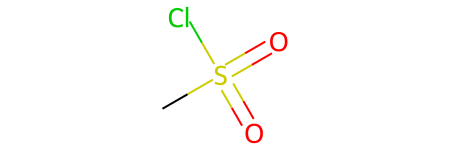

[1, 4, 3, 3, 5, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0]
[1, 1, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0]
[4, 4, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 2, 1, 3, 1, 4, 0, 5, 0, 6, 0, 7]
[1, 0, 2, 1, 3, 1, 4, 1, 5, 0, 6, 0, 7, 0]
[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False]
[rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Chem.rdchem.BondStereo.STEREONONE, rdkit.Chem.rdchem.Bo

In [29]:
mol = Chem.MolFromSmiles(molecules_data.iloc[1, 1])
AllChem.Compute2DCoords(mol)
display(mol)

data = generate_graphs(molecules_data)
for d in data[1]:
    print(d)

Видно, что массив содержит разные типы данных. При конвертации pytorch ternsor за счет закоментированных выше строк все было бы приведено к одному типу

**Пример разбиения данных данных:**

In [33]:
# для разбиения данных используем рандомизированный массив индексов от 0 до 641
permuted_indices = np.random.permutation(np.arange(molecules_data.shape[0]))

# разбиение данных проводим в соотношении 9 к 1
train_index = permuted_indices[: int(molecules_data.shape[0] * 0.9)] # деление произведем по индексу
x_train = generate_graphs(molecules_data.iloc[train_index])
y_train = molecules_data.iloc[train_index].expt

# тестовая выборка - оставшиеся 10 % 
test_index = permuted_indices[int(molecules_data.shape[0] * 0.9) :]
x_test = generate_graphs(molecules_data.iloc[test_index])
y_test = molecules_data.iloc[test_index].expt

print(f'Данные для обучения содержат {len(y_train)} молекул, тестовый набор - {len(y_test)} молекул')

Данные для обучения содержат 577 молекул, тестовый набор - 65 молекул


<AxesSubplot:xlabel='expt', ylabel='Count'>

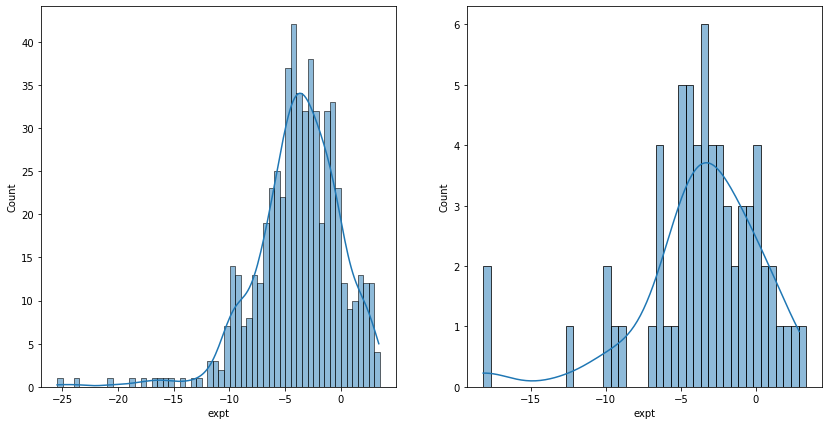

In [38]:
# сравним распределение данных в полученных подвыборках с исходной
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax = ax.flatten()

sns.histplot(y_train, binwidth=0.5, kde=True, ax=ax[0])
sns.histplot(y_test, binwidth=0.5, kde=True, ax=ax[1])

Обучающая и тестовая выборки выходят весьма репрезентативными